# Requirement 2

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Pricing problem

In [136]:
class AdversarialPricingEnvironment:
    def __init__(self, prices, loss_sequence):
        self.prices = prices
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self, p_t):
        a_t = np.where(self.prices == p_t)
        l_t = self.loss_sequence[self.t, a_t]
        self.t += 1
        return l_t

In [137]:
# Pricing emvironment variables
max_price = 20
min_price = 10
cost = min_price # I set the cost to min price because that is the worst case for the seller (0 profit on a sale)
T = 10000  # Total number of days
daily_customers = 100  # Number of auction rounds per day
K = 100  # Number of discrete prices

reward_function = lambda price, cost, n_sales: (price - cost) * n_sales
loss_function = lambda cost, reward: reward_function(max_price, cost, daily_customers) - reward

prices = np.linspace(min_price,max_price, K) # 100 different prices between 10 and 20

In [138]:
buying_probabilities = np.zeros((T, K))
for t in range(T):
    buying_probabilities[t] = np.random.rand(K)

loss_sequence = np.zeros((T, K))
for t in range(T):
    for k in range(K):
        loss_sequence[t, k] = loss_function(cost, reward_function(prices[k], cost, np.random.binomial(daily_customers, buying_probabilities[t, k])))

In [139]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [140]:
learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

best_arm = np.argmin(loss_sequence.sum(axis=0))
clairvoyant_losses = loss_sequence[:, best_arm]

n_trials = 20

regret_per_trial = []
# we keep the loss sequence fixed, we will only observe uncertainty due to algorithm's randomizations
for trial in tqdm(range(n_trials)):

    agent = EXP3Agent(K, learning_rate)
    env = AdversarialPricingEnvironment(prices, loss_sequence)
    
    agent_losses = np.array([])
    expected_agent_losses = np.array([])
    for t in range(T):
        a_t = agent.pull_arm()
        p_t = prices[a_t]
        l_t = env.round(p_t)
        agent.update(l_t/daily_customers)
        # logging
        agent_losses = np.append(agent_losses, l_t)
        expected_agent_losses = np.append(expected_agent_losses, np.dot(agent.x_t, env.loss_sequence[t-1,:])) 

    cumulative_regret = np.cumsum(expected_agent_losses-clairvoyant_losses)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
print(regret_per_trial.shape)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\rbegl\AppData\Local\Temp\ipykernel_7496\2079954555.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
100%|██████████| 20/20 [00:17<00:00,  1.14it/s]

(20, 10000)


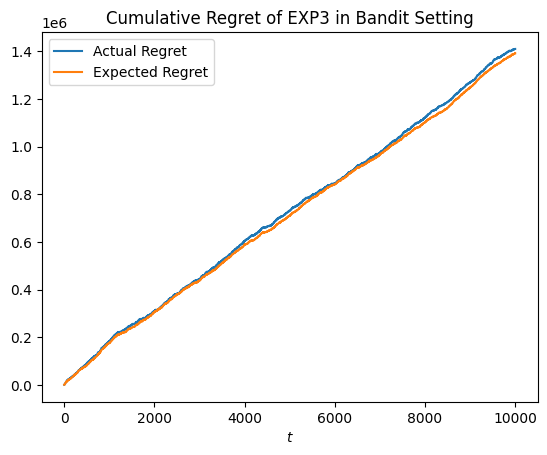

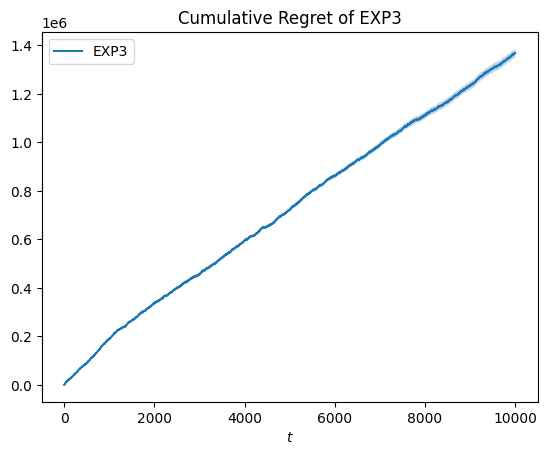

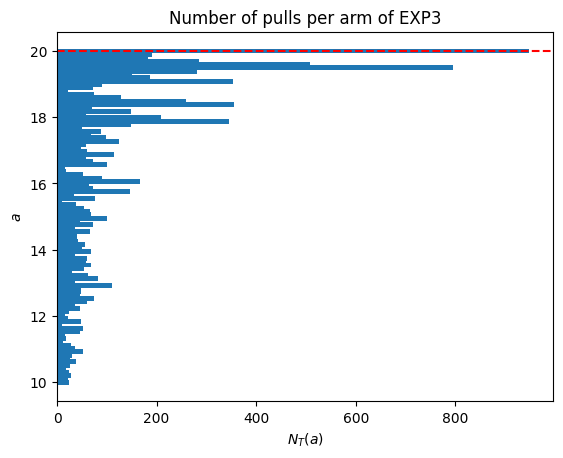

In [146]:
plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Regret')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='Expected Regret')
plt.title('Cumulative Regret of EXP3 in Bandit Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.plot(np.arange(T), average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=prices, width=agent.N_pulls, height=0.15)
plt.title('Number of pulls per arm of EXP3')
plt.axhline(prices[best_arm], color='red', label='Best Arm', linestyle='--')
plt.ylabel('$a$')
plt.xlabel('$N_T(a)$')
plt.show()

### Auction Problem

In [142]:
class BiddingAgent:
    def __init__(self, bids_set, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, eta)
        self.T = T
        self.t = 0

    def bid(self):
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t_full):
      # todo: implement this
      return


In [143]:
class NonStationaryFirstPriceAuction:
    def __init__(self, available_bids, num_bidders, num_rounds):
        self.available_bids = available_bids
        self.num_bidders = num_bidders
        self.num_rounds = num_rounds
        self.round_counter = 0
        self.bids = self._generate_bids()

    def _generate_bids(self):
        return np.random.choice(self.available_bids, (self.num_rounds, self.num_bidders))

    def reset(self):
        self.bids = self._generate_bids()
        self.round_counter = 0

    def round(self, agent_bid):
        current_round_bids = self.bids[self.round_counter]
        max_bid = np.max(current_round_bids)
        win = agent_bid > max_bid
        self.round_counter += 1
        return max_bid, win


In [144]:
# Initialize Hedge agent for bidding strategy
available_bids = np.linspace(0, 1, K)  # Example bid space from 0 to 1
eta = np.sqrt(np.log(len(available_bids)) / (daily_customers * T))  # Learning rate for Hedge
bidding_agent = BiddingAgent(bids_set=available_bids, T=daily_customers * T, eta=eta)
num_bidders = 10
# Initialize Environment and Auction
env = AdversarialPricingEnvironment(num_arms=K, change_interval=change_interval)
auction = NonStationaryFirstPriceAuction(available_bids=available_bids, num_bidders=num_bidders, num_rounds=daily_customers)
pricing_agent = UCB1(num_arms=K)

# Simulation loop with auction and Hedge agent
total_rewards = 0
cumulative_regret = 0
cumulative_rewards = []
daily_regrets = []
daily_rewards = []
daily_probabilities = []

for day in range(T):
    env.reset()
    auction.reset()

    daily_probabilities.append(env.buying_probabilities.copy())

    chosen_price = pricing_agent.pull_arm()

    daily_reward = 0
    for round in range(daily_customers):
        agent_bid = bidding_agent.bid()

        max_bid, win = auction.round(agent_bid)

        if win:
            if env.round(chosen_price):
                daily_reward += 1

        reward = (env.buying_probabilities[chosen_price] - agent_bid) if win else -agent_bid
        f_t_full = np.array([(env.buying_probabilities[chosen_price] - b) if b < agent_bid else -b for b in available_bids])
        bidding_agent.update(f_t_full)

    pricing_agent.update(chosen_price, daily_reward)
    total_rewards += daily_reward

    optimal_reward = np.max(env.buying_probabilities) * daily_customers
    daily_regret = optimal_reward - daily_reward
    cumulative_regret += daily_regret

    daily_rewards.append(daily_reward)
    daily_regrets.append(daily_regret)
    cumulative_rewards.append(total_rewards)

    print(f"Day {day+1}, Daily Reward: {daily_reward}, Total Rewards: {total_rewards}, Daily Regret: {daily_regret}, Cumulative Regret: {cumulative_regret}")

cumulative_probabilities = np.mean(daily_probabilities, axis=0)
optimal_arm = np.argmax(cumulative_probabilities)

most_pulled_arm = np.argmax(pricing_agent.counts)

print(f"Simulation completed. Total rewards: {total_rewards}")
print(f"Cumulative regret: {cumulative_regret}")
print(f"Most pulled arm: {most_pulled_arm}")
print(f"Arm that should have been pulled the most: {optimal_arm}")


NameError: name 'change_interval' is not defined

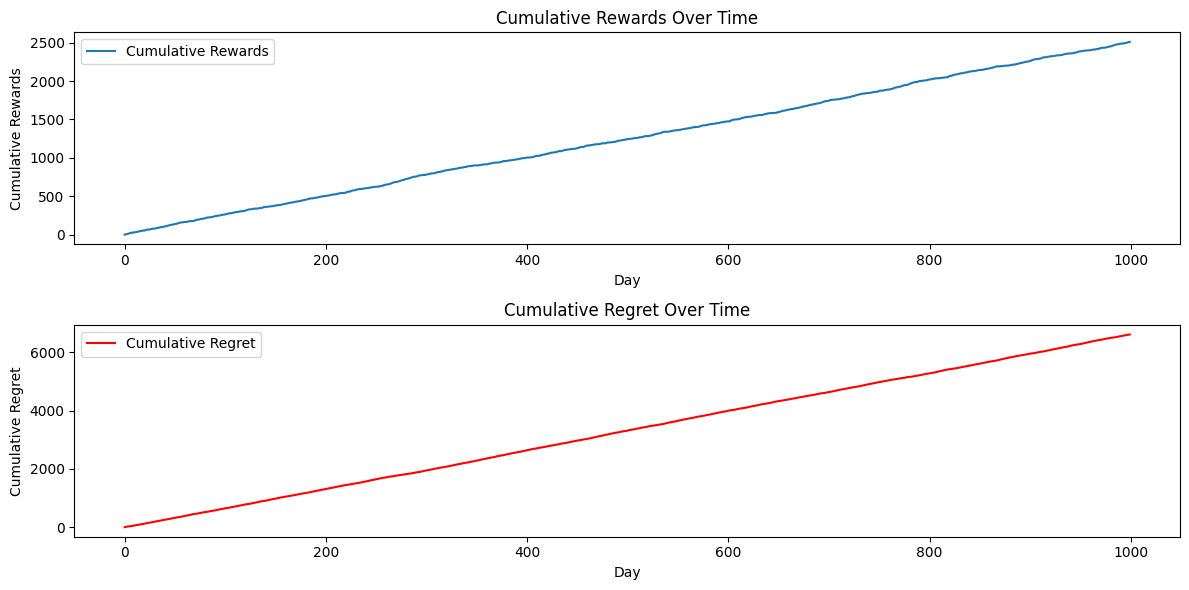

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(range(T), cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Day')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards Over Time')
plt.legend()

# Plot cumulative regret
plt.subplot(2, 1, 2)
plt.plot(range(T), np.cumsum(daily_regrets), label='Cumulative Regret', color='red')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.legend()

plt.tight_layout()
plt.show()